# Satvinder Singh Panesar

In [1]:
#below line installs twitteR package
#install.packages("twitteR",repos='http://cran.rstudio.com/')

In [2]:
#imports
library("twitteR")
#below line imports library for write_csv
library("readr")
#below library useful for checking one string conatins other (str_detect)
library(stringr)
library(maps)

Warning message:
"package 'twitteR' was built under R version 3.4.3"Warning message:
"package 'stringr' was built under R version 3.4.3"Warning message:
"package 'maps' was built under R version 3.4.3"

In [3]:
#flag to control tweet collection
collect_tweets <- FALSE

In [4]:
if(collect_tweets==TRUE){
    setup_twitter_oauth("t2R6IZqWb5tlaDEJOXRSXjIzR", "0fjbeYfbZPb2fbAUbE9w15264dUPdsPNIlpPfFSSJeBLRZCuMk")    
}

In [5]:
#getting tweets
if(collect_tweets == TRUE){
    search_date <- '2018-03-07'
    #get tweets for date specified
    keywords <- c("flu","influenza")
    for(keyword in keywords){
        #until uses date + 1 because it doesnt consider the given day
        tweets <- searchTwitter(keyword, n=5000, since=toString(search_date), until=toString(as.Date(search_date)+1), lang='en')
        tweets <- twListToDF(tweets)
        #below line creates folder called tweets 
        dir.create("tweets", showWarnings = FALSE)
        dir.create(paste("tweets/",search_date,sep=""), showWarnings = FALSE)
        write_csv(tweets, paste("tweets/",search_date,"/",keyword,"_tweets.csv",sep=""), append=FALSE)
        #below line will get screen names from user tweets
        screen_names <- tweets$screenName
        write_csv(as.data.frame(screen_names), paste("tweets/",search_date,"/",keyword,"_screen_names.csv",sep=""), append=FALSE)
        #below line will get user info
        users_info <- twListToDF(lookupUsers(screen_names))
        write_csv(users_info, paste("tweets/",search_date,"/",keyword,"_users_info.csv",sep=""), append=FALSE)
        #below line will give locations of users
        #iconv will convert locations to ASCII, so we get rid of any special characters\n",
        locations <- tolower(iconv(users_info$location, to = "ASCII//TRANSLIT"))
        write_csv(as.data.frame(locations), paste("tweets/",search_date,"/",keyword,"_locations.csv",sep=""), append=FALSE)    
    }
}

In [6]:
#reading stored tweets and getting locations
folders <- list.files("./tweets", full.names=TRUE)
locations <- c()
for(folder in folders){
    # get files with name ending with locations.csv, beacuse files will have search keyword as their prefix
    files <- list.files(folder, full.names=TRUE, pattern="*locations.csv")
    for(file in files){
        #using read_csv because it takes care of empty list elements
        data <- as.data.frame(read_csv(file))
        for(ele in data){
            locations <- c(locations,ele)
        }
    }
}

Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_character()
)
Parsed with column specification:
cols(
  locations = col_charac

In [7]:
#pre processing
#na.omit takes care of null values
locations <- na.omit(locations)
#below data for state abbreviations is taken from http://www.stateabbreviations.us/
#what I am doing is replace abbreviations in user's location obtained from twitter and replace it with their full forms
#Ex: TX is changed to texas
state_abbs <- read_csv("StateAbbreviations.csv")
state_names <- state_abbs[[1]]
#below lower case conversion is done so as to perform case insentitive comparison
state_names <- tolower(state_names)
postal_abbs <- state_abbs[[3]]
postal_abbs <- tolower(postal_abbs)
location_index <- 1
code_index <- 1

for(location in locations){
    code_index <- 1
    for(ele in postal_abbs){
        # replacing state abbreviations with their full names
        if(str_detect(location,paste(", ",ele,sep="")))
            locations[location_index] <- state_names[code_index]
        else if(str_detect(location,paste(",",ele,sep="")))
            locations[location_index] <- state_names[code_index]    
        else if(str_detect(location,paste(" ",ele,sep="")))
            locations[location_index] <- state_names[code_index]   
        else if(str_detect(location,paste(ele," ",sep="")))
            locations[location_index] <- state_names[code_index]   
        code_index <- code_index + 1   
    }
    location_index <- location_index + 1
}

Parsed with column specification:
cols(
  State = col_character(),
  Standard = col_character(),
  Postal = col_character(),
  `Capital City` = col_character()
)


In [8]:
#debug only
print(paste("Number of locations obtained from twitter data",length(locations)))

[1] "Number of locations obtained from twitter data 66724"


In [9]:
#getting location count
states <- map("state",namesonly=TRUE, plot=FALSE)
#print(length(states))
count <- c()
for(state in states){
    temp <- 0
    for(location in locations){
        if(str_detect(location,state)){
            temp <- temp + 1
        }
    }
    count <- c(count,temp)
}

In [10]:
#debug only
print(paste("Number of locations used to plot twitter data heatmap",sum(count)))

[1] "Number of locations used to plot twitter data heatmap 30821"


In [11]:
#calculating colors, every 10% of data defines a level
max_value <- max(count)
min_value <- min(count)
difference <- max_value - min_value
interval <- as.integer(difference/10)
colors <- c()
for(ele in count){
    if(ele >= (max_value-interval))
        colors <- c(colors,"firebrick4") #level 10
    else if(ele >= (max_value-2*interval))
        colors <- c(colors,"firebrick3") #level 9
    else if(ele >= (max_value-3*interval))
        colors <- c(colors,"firebrick1") #level 8
    else if(ele >= (max_value-4*interval))
        colors <- c(colors,"dodgerblue4") #level 7
    else if(ele >= (max_value-5*interval))
        colors <- c(colors,"dodgerblue3") #level 6
    else if(ele >= (max_value-6*interval))
        colors <- c(colors,"dodgerblue1") #level 5
    else if(ele >= (max_value-7*interval))
        colors <- c(colors,"yellow1") #level 4
    else if(ele >= (max_value-8*interval))
        colors <- c(colors,"palegreen2") #level 3
    else if(ele >= (max_value-9*interval))
        colors <- c(colors,"palegreen3") #level 2
    else
        colors <- c(colors,"palegreen4") #level 1
}

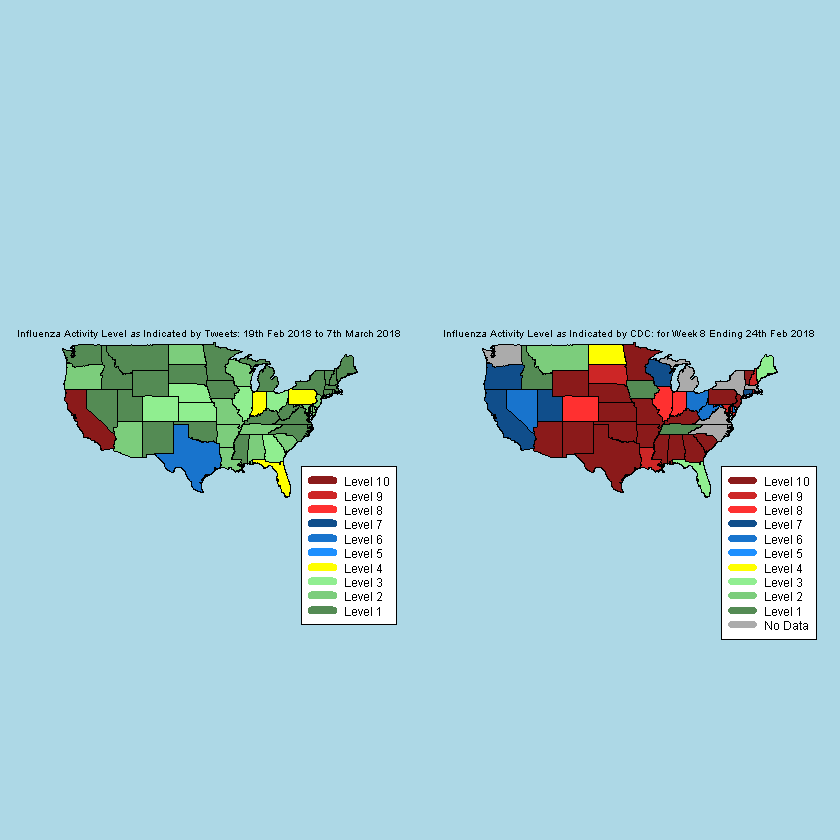

In [12]:
#below line is used to show maps side to side
par(mfrow=c(1,2))

#plotting heat map as indicated by tweets
map("state", col=colors, fill=TRUE, bg="lightblue")
legend_colors <- c("firebrick4","firebrick3","firebrick1","dodgerblue4","dodgerblue3", "dodgerblue1","yellow1", "palegreen2", "palegreen3", "palegreen4")
legends <- c("Level 10","Level 9","Level 8","Level 7", "Level 6", "Level 5", "Level 4", "Level 3", "Level 2", "Level 1")
par(xpd=TRUE)
legend(-78, 30, legend=legends, col=legend_colors, lwd=7, cex=0.6)
mtext("Influenza Activity Level as Indicated by Tweets: 19th Feb 2018 to 7th March 2018", side=3, cex = 0.5)


#plotting heat map as indicated by CDC data for Week 8 Ending 24th Feb 2018

library(maps)
# below line is only used to obtain state names and accordingly extra states are removed from input file
states <- map("state",namesonly=TRUE, plot=FALSE)
data <- read.csv("StateDataforMap_2017-18week8.csv")
data$STATENAME <- tolower(data$STATENAME)
colors <- c()

for(state in states){
    index <- 1
    assigned <- FALSE
    for(ele in data$STATENAME){
        if(state == ele){
            #set color based on temperature
            if(data$ACTIVITY.LEVEL[index]=="Level 10"){
                colors <- c(colors,"firebrick4")
            }
            else if(data$ACTIVITY.LEVEL[index]=="Level 9"){
                colors <- c(colors,"firebrick3")
            }
            else if(data$ACTIVITY.LEVEL[index]=="Level 8"){
                colors <- c(colors,"firebrick1")
            }
            else if(data$ACTIVITY.LEVEL[index]=="Level 7"){
                colors <- c(colors,"dodgerblue4")
            }
            else if(data$ACTIVITY.LEVEL[index]=="Level 6"){
                colors <- c(colors,"dodgerblue3")
            }
            else if(data$ACTIVITY.LEVEL[index]=="Level 5"){
                colors <- c(colors,"dodgerblue1")
            }
            else if(data$ACTIVITY.LEVEL[index]=="Level 4"){
                colors <- c(colors,"yellow1")
            }
            else if(data$ACTIVITY.LEVEL[index]=="Level 3"){
                colors <- c(colors,"palegreen2")
            }
            else if(data$ACTIVITY.LEVEL[index]=="Level 2"){
                colors <- c(colors,"palegreen3")
            }
            else if(data$ACTIVITY.LEVEL[index]=="Level 1"){
                colors <- c(colors,"palegreen4")
            }
            assigned <- TRUE
            break
        }
        index <- index + 1
    }
     if(assigned == FALSE){
        colors <- c(colors,"gray67")
    }
}
map("state", col=colors, fill=TRUE, bg="lightblue")
colors <- c("firebrick4","firebrick3","firebrick1","dodgerblue4","dodgerblue3", "dodgerblue1","yellow1", "palegreen2", "palegreen3", "palegreen4","gray67")
legends <- c("Level 10","Level 9","Level 8","Level 7", "Level 6", "Level 5", "Level 4", "Level 3", "Level 2", "Level 1","No Data")
#to prevent clipping of legend i.e. it allows legend to be drawn beyond map limits
par(xpd=TRUE)
#par("usr")
legend(-78, 30, legend=legends, col=colors, lwd=6, cex=0.6)
mtext("Influenza Activity Level as Indicated by CDC: for Week 8 Ending 24th Feb 2018", side=3, cex=0.5)